### Importing Libraries

In [ ]:
!pip install scorecardpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60629 sha256=21bf91b72f1395554df84c885541701d9b71d4efb8855ba52b481605948d6a17
  Stored in directory: /root/.cache/pip/wheels/68/88/65/58d6aa058698c47d7a24352952ea07a1409cc2eff3a8087c0c
Successfully built scorecardpy


In [ ]:
import warnings

# To ignore all warnings:
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
import scorecardpy as sc
from sklearn.preprocessing import MinMaxScaler




### Loading the Data


In [ ]:
# Load the dataset
data = pd.read_csv('exploratory_data_analysis.csv')

In [ ]:
# Convert datetime to pandas datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

In [ ]:
# Display the first few rows of the dataset
data.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [ ]:
# Check for missing values
data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [ ]:
# Check data types
data.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [ ]:
# Descriptive statistics for numerical columns
data.describe()


datetime        season       holiday  \
count                          10886  10886.000000  10886.000000   
mean   2011-12-27 05:56:22.399411968      2.506614      0.028569   
min              2011-01-01 00:00:00      1.000000      0.000000   
25%              2011-07-02 07:15:00      2.000000      0.000000   
50%              2012-01-01 20:30:00      3.000000      0.000000   
75%              2012-07-01 12:45:00      4.000000      0.000000   
max              2012-12-19 23:00:00      4.000000      1.000000   
std                              NaN      1.116174      0.166599   

         workingday       weather         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.680875      1.418427     20.23086     23.655084     61.886460   
min        0.000000      1.000000      0.82000      0.760000      0.000000   
25%        0.000000      1.000000     13.94000     16.665000     47.000000   
50%        1.000000      1.000000     20.50000     24.240000     62.000000   
75%        1.000000      2.000000     26.24000     31.060000     77.000000   
max        1.000000      4.000000     41.00000     45.455000    100.000000   
std        0.466159      0.633839      7.79159      8.474601     19.245033   

          windspeed        casual    registered         count  
count  10886.000000  10886.000000  10886.000000  10886.000000  
mean      12.799395     36.021955    155.552177    191.574132  
min        0.000000      0.000000      0.000000      1.000000  
25%        7.001500      4.000000     36.000000     42.000000  
50%       12.998000     17.000000    118.000000    145.000000  
75%       16.997900     49.000000    222.000000    284.000000  
max       56.996900    367.000000    886.000000    977.000000  
std        8.164537     49.960477    151.039033    181.144454

In [ ]:
# Check for duplicate rows
data.duplicated().sum()


0

In [ ]:
# Check unique values in each column
for column in data.select_dtypes(include=['object', 'category']).columns:
    print(f"Unique values in {column}: {data[column].nunique()}")


In [ ]:
# # Value counts for categorical columns
# for column in data.select_dtypes(include=['object', 'category']).columns:
#     print(f"Value counts for {column}:\n", data[column].value_counts())


### Inspecting the Data



In [ ]:
# Extract useful time-based features
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['day_of_week'] = data['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
data['hour'] = data['datetime'].dt.hour

# Check the modified dataframe
data.head()


datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  year  month  day  \
0        81        0.0       3          13     16  2011      1    1   
1        80        0.0       8          32     40  2011      1    1   
2        80        0.0       5          27     32  2011      1    1   
3        75        0.0       3          10     13  2011      1    1   
4        75        0.0       0           1      1  2011      1    1   

   day_of_week  hour  
0            5     0  
1            5     1  
2            5     2  
3            5     3  
4            5     4

In [ ]:
# Check the time period range
data['datetime'].min(), data['datetime'].max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

Feature correlations with 'count':
count          1.000000
registered     0.970948
casual         0.690414
hour           0.400601
temp           0.394454
atemp          0.389784
datetime       0.310187
year           0.260403
month          0.166862
season         0.163439
windspeed      0.101369
day            0.019826
workingday     0.011594
day_of_week   -0.002283
holiday       -0.005393
weather       -0.128655
humidity      -0.317371
Name: count, dtype: float64


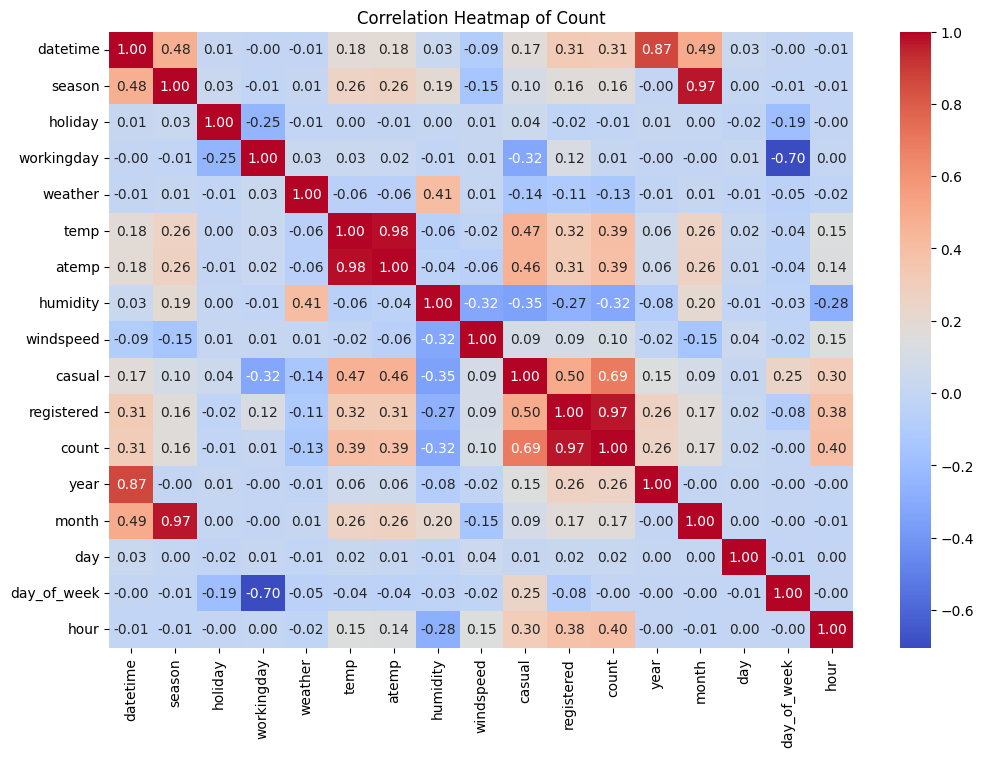

In [ ]:
# Testing Feature correlation with count
print("Feature correlations with 'count':")
correlations = data.corr()['count'].sort_values(ascending=False)
print(correlations)

# Visualizing correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Count')
plt.show()

####  Exploring Numerical Data

In [ ]:

# Function to plot histogram for any column in the dataframe
def Histogram_plot(data, column_name, color_, bins=30, kde=True):
    """
    Function to plot a histogram for a specified column in the data.

    Parameters:
    data (DataFrame): The dataset containing the column to plot.
    column_name (str): The name of the column to plot.
    color_ (str): The color of the histogram.
    bins (int, optional): The number of bins to display. Default is 30.
    kde (bool, optional): Whether to display the kernel density estimate. Default is True.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column_name], kde=kde, bins=bins, color=color_)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Frequency')
    plt.show()




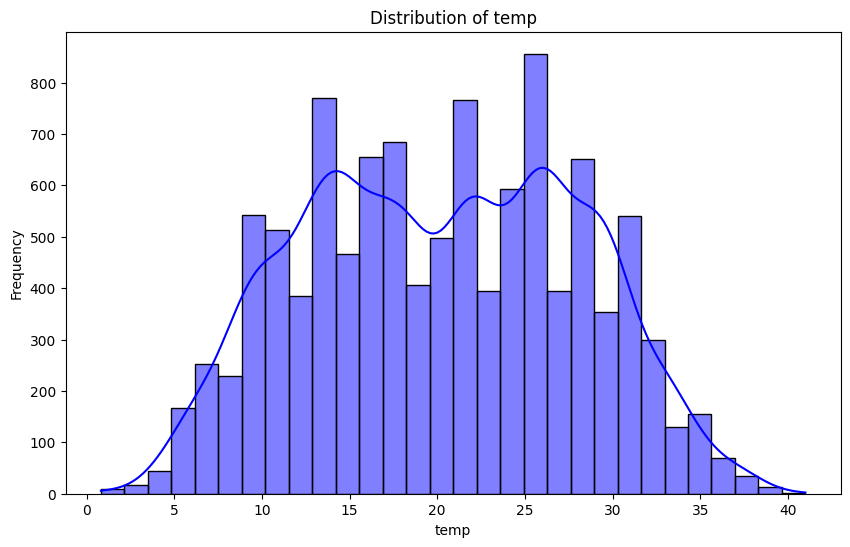

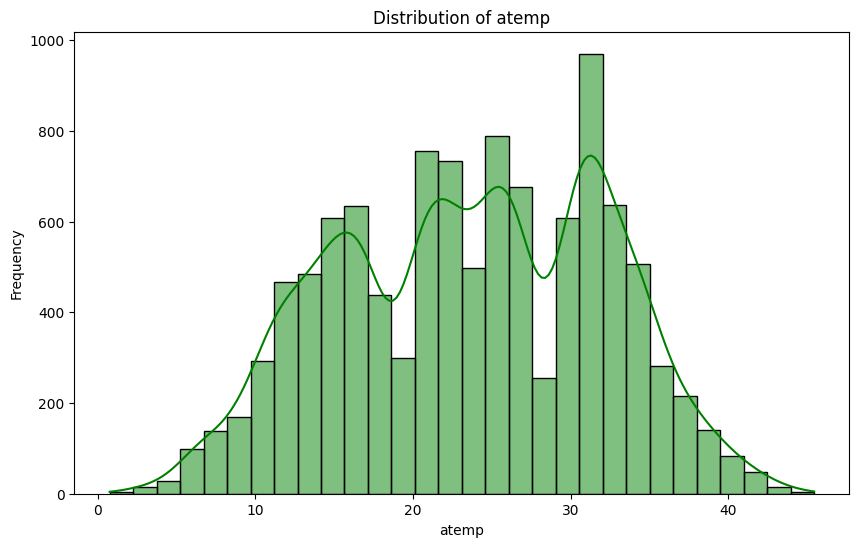

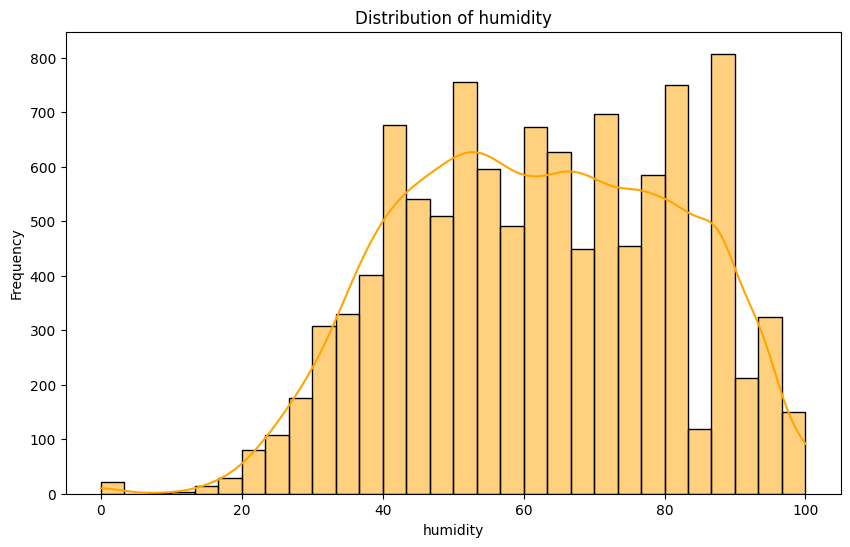

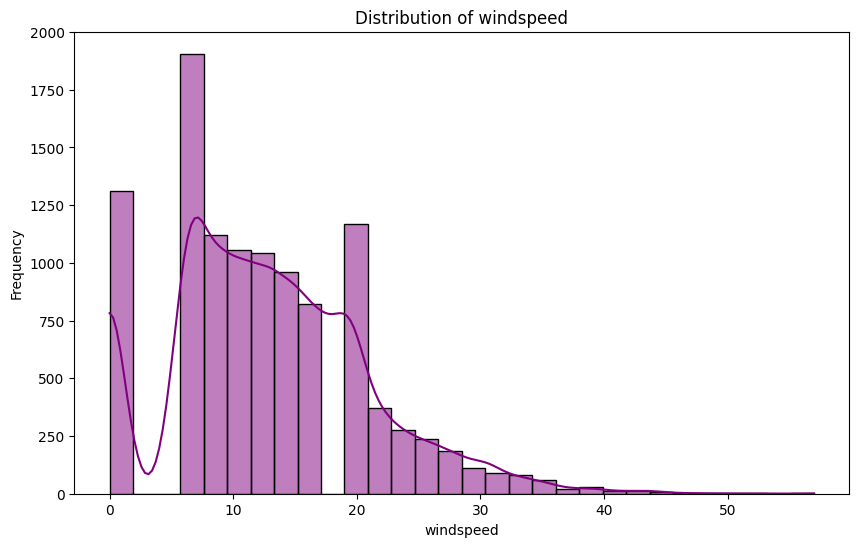

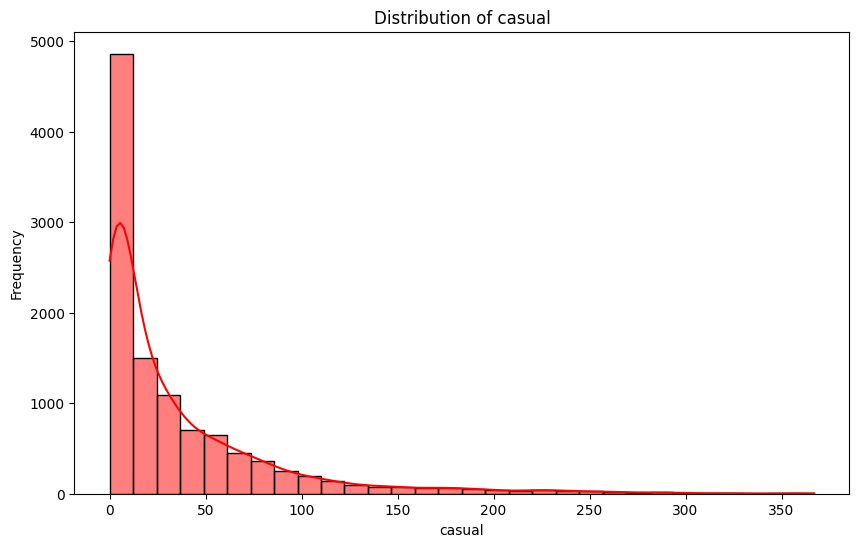

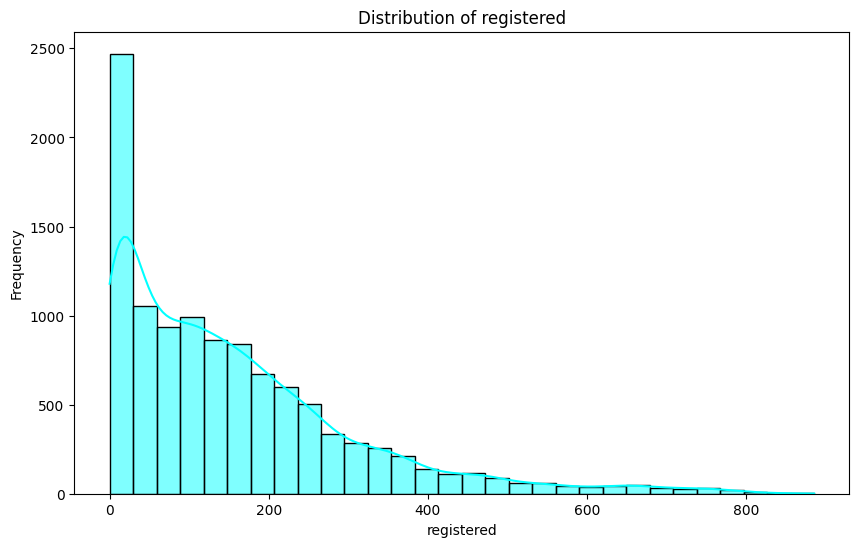

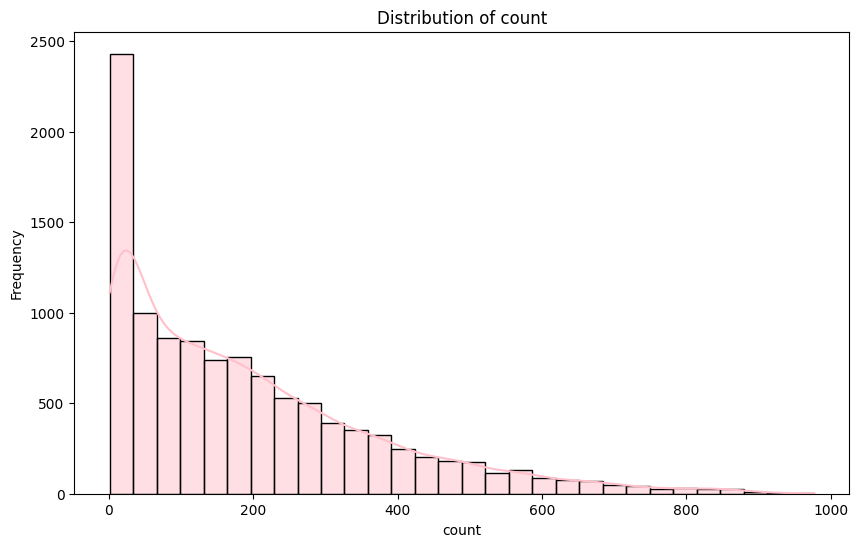

In [ ]:
# Histogram for 'temp' (Temperature in Celsius)
Histogram_plot(data, 'temp', color_='blue')

# Histogram for 'atemp' ("Feels like" temperature in Celsius)
Histogram_plot(data, 'atemp', color_='green')

# Histogram for 'humidity' (Relative humidity)
Histogram_plot(data, 'humidity', color_='orange')

# Histogram for 'windspeed' (Wind speed in km/h)
Histogram_plot(data, 'windspeed', color_='purple')

# Histogram for 'casual' (Non-registered user rentals)
Histogram_plot(data, 'casual', color_='red')

# Histogram for 'registered' (Registered user rentals)
Histogram_plot(data, 'registered', color_='cyan')

# Histogram for 'count' (Total number of rentals)
Histogram_plot(data, 'count', color_='pink')


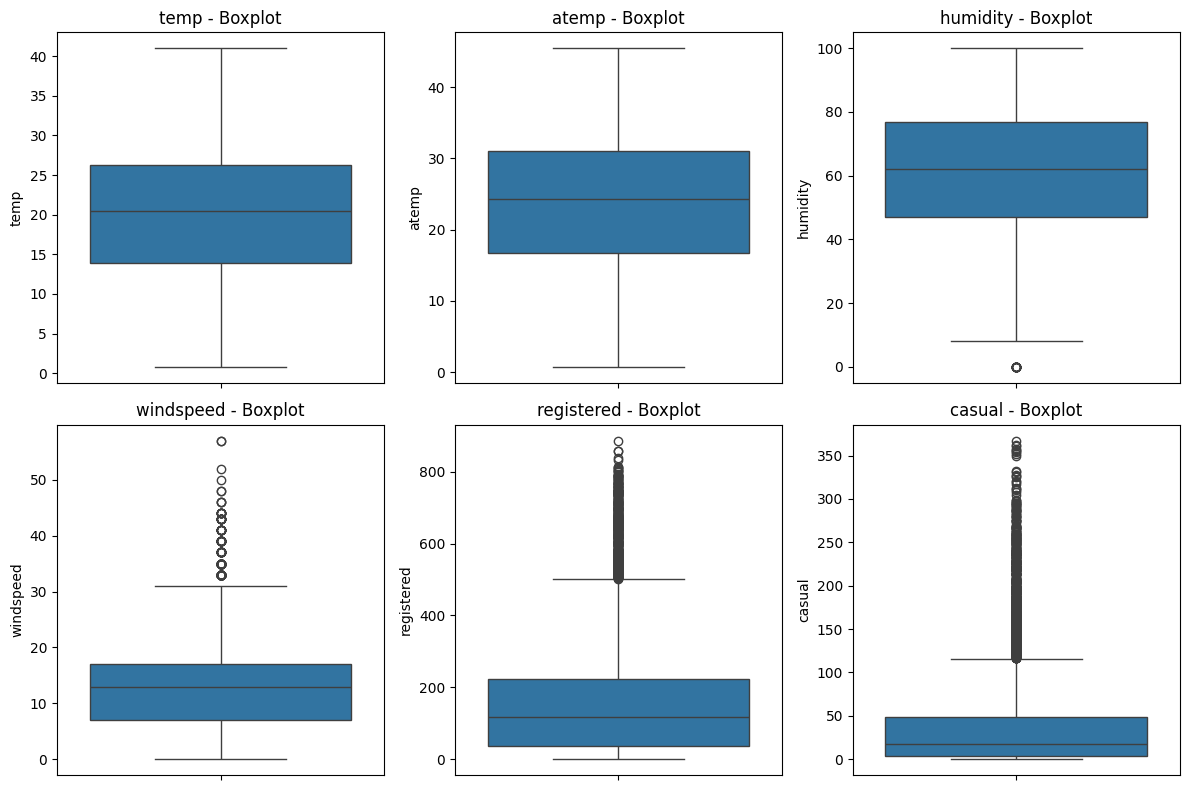

In [ ]:
# Boxplot for numerical columns to check for outliers/extreme values

numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'registered', 'casual']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[col])
    plt.title(f'{col} - Boxplot')
plt.tight_layout()
plt.show()


In [ ]:


# Function to create box plot for numerical variables by category (e.g., season, hour)
def Boxplot_by_category(data, column_name, category_column, color_, title_):
    """
    Function to create a box plot of a numerical column grouped by a categorical column.

    Parameters:
    data (DataFrame): The dataset containing the columns.
    column_name (str): The name of the numerical column to plot.
    category_column (str): The categorical column by which the data is grouped.
    color_ (str): The color for the box plot.
    title_ (str): The title for the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=category_column, y=column_name, data=data, color=color_)
    plt.title(title_)
    plt.xlabel(category_column.capitalize())
    plt.ylabel(column_name.capitalize())
    plt.show()



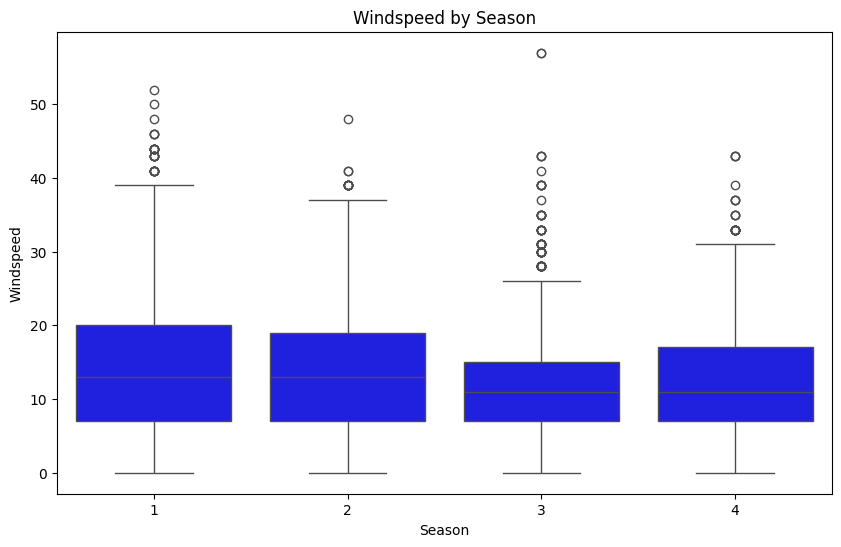

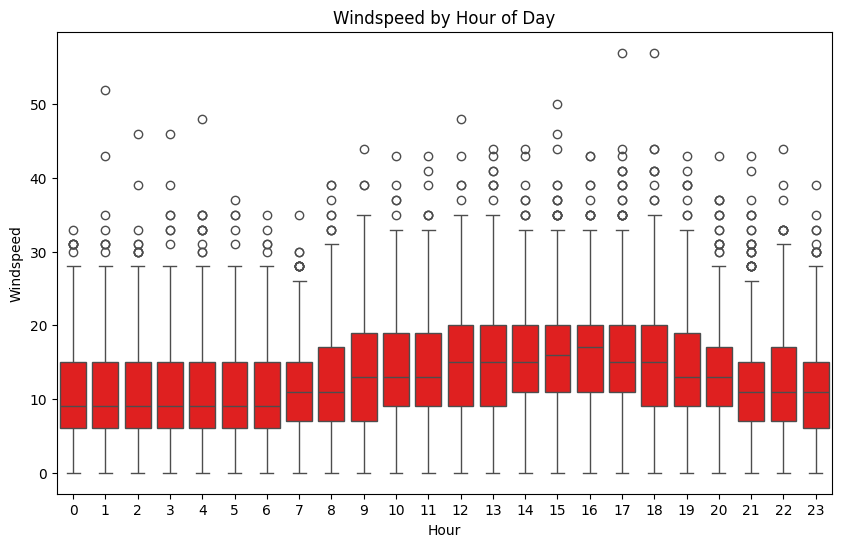

In [ ]:
# Boxplot for windspeed by season
Boxplot_by_category(data, 'windspeed', 'season', color_='blue', title_='Windspeed by Season')


# Boxplot for windspeed by hour of day
Boxplot_by_category(data, 'windspeed', 'hour', color_='red', title_='Windspeed by Hour of Day')




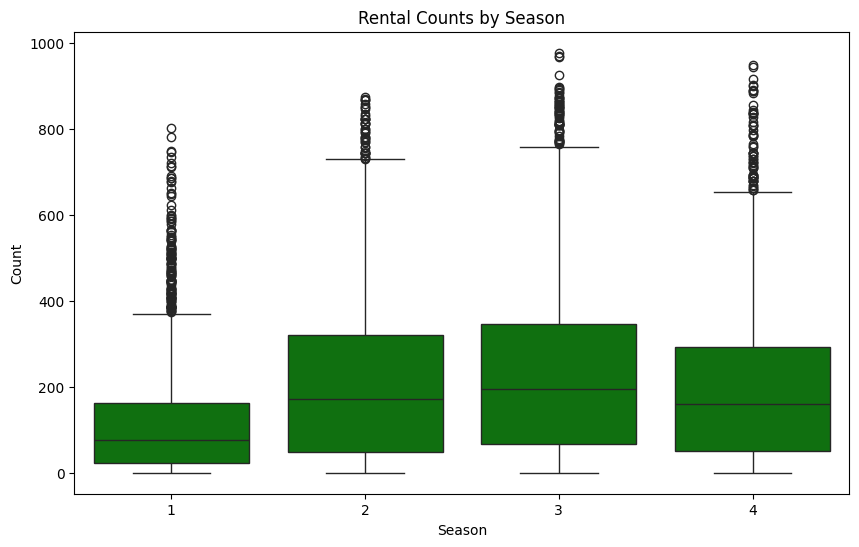

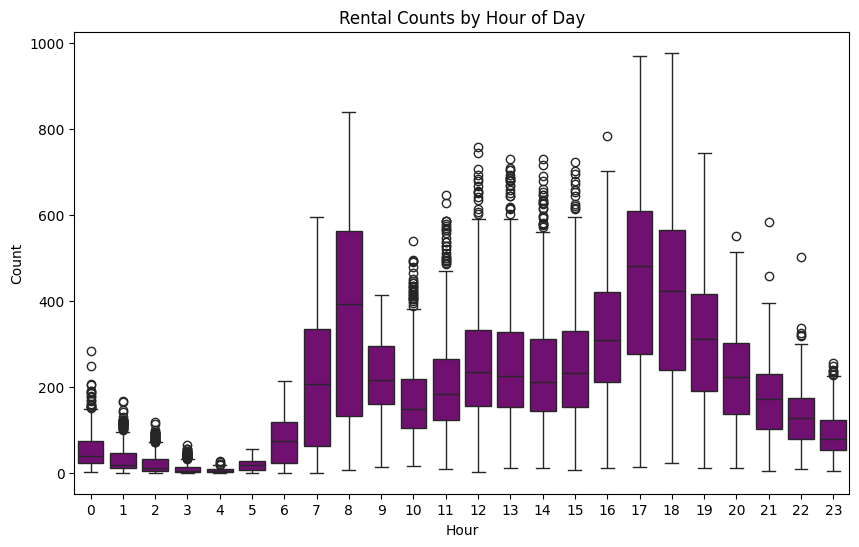

In [ ]:
# Boxplot for count by season
Boxplot_by_category(data, 'count', 'season', color_='green', title_='Rental Counts by Season')

# Boxplot for rental counts by hour of day
Boxplot_by_category(data, 'count', 'hour', color_='purple', title_='Rental Counts by Hour of Day')


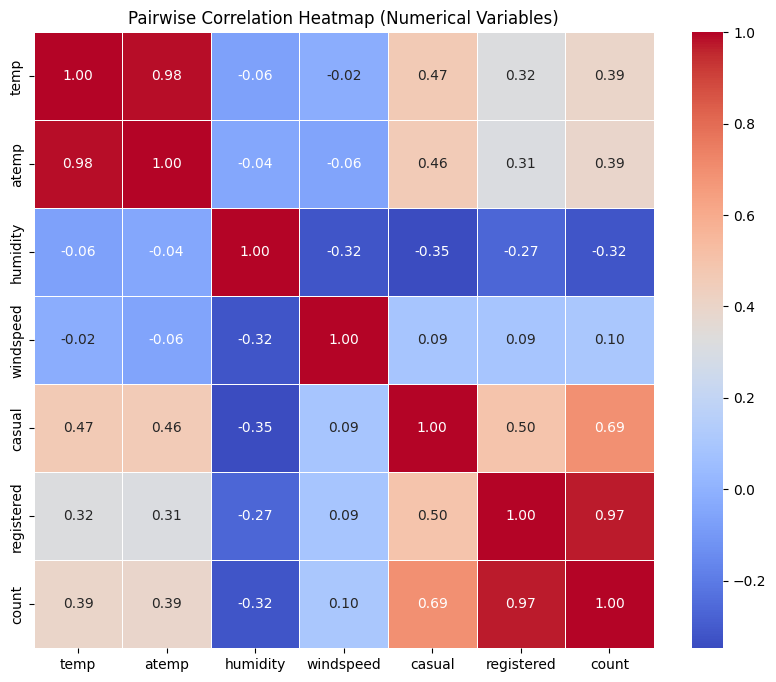

In [ ]:
# Numerical Heatmap:

# Darker colors in the heatmap (e.g., red or blue) indicate stronger positive or negative correlations.
# Values closer to 1 or -1 imply stronger relationships.

def numerical_correlation_heatmap(data, numerical_columns):
    # Compute the correlation matrix
    corr_matrix = data[numerical_columns].corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Pairwise Correlation Heatmap (Numerical Variables)')
    plt.show()

# List of numerical columns
numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

# Call the function
numerical_correlation_heatmap(data, numerical_columns)


#### Exploring Categorical Data

In [ ]:
# Frequency distribution for a categorical column
def categorical_frequency(data, column):
    print(data[column].value_counts())
    print("\nPercentage distribution:")
    print(data[column].value_counts(normalize=True) * 100)

# Bar plot for categorical variable
def categorical_barplot(data, column, color_='Blues'):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column, palette=color_)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# Cross-tabulation between two categorical variables
def categorical_crosstab(data, column1, column2):
    print(pd.crosstab(data[column1], data[column2], margins=True))

# Box plot to analyze relationship between categorical variable and numerical variable
def categorical_vs_numerical_boxplot(data, categorical_column, numerical_column, color_='Purples'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categorical_column, y=numerical_column, data=data, palette=color_)
    plt.title(f'{numerical_column} by {categorical_column}')
    plt.xlabel(categorical_column)
    plt.ylabel(numerical_column)
    plt.show()

# Chi-Square test for independence between two categorical variables
def chi_square_test(data, column1, column2):
    contingency_table = pd.crosstab(data[column1], data[column2])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print(f"The variables {column1} and {column2} are dependent (reject H0).")
    else:
        print(f"The variables {column1} and {column2} are independent (fail to reject H0).")


# Stacked bar plot for multiple categorical variables
def categorical_stacked_barplot(data, categorical_columns):
    crosstab = pd.crosstab(index=data[categorical_columns[0]], columns=data[categorical_columns[1]])
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Stacked Bar Plot of {categorical_columns[0]} and {categorical_columns[1]}')
    plt.xlabel(categorical_columns[0])
    plt.ylabel('Count')
    plt.show()



season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64

Percentage distribution:
season
4    25.114826
2    25.105640
3    25.105640
1    24.673893
Name: proportion, dtype: float64


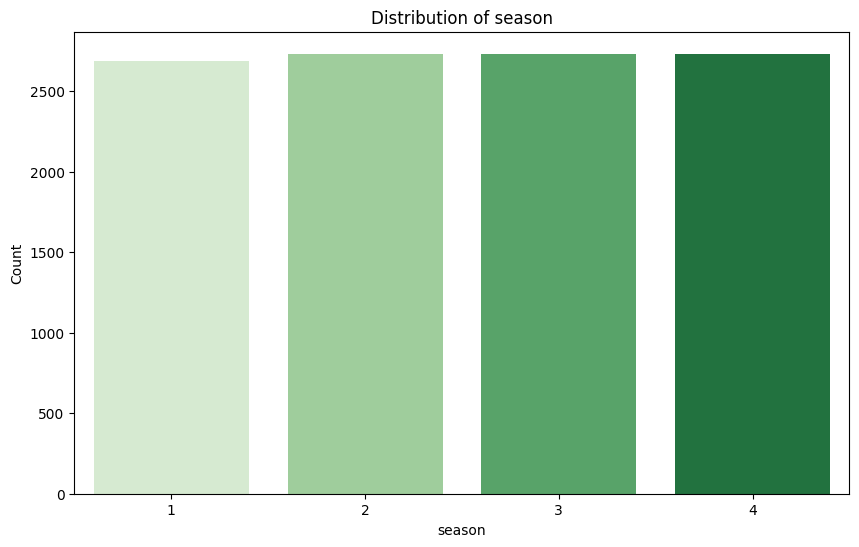

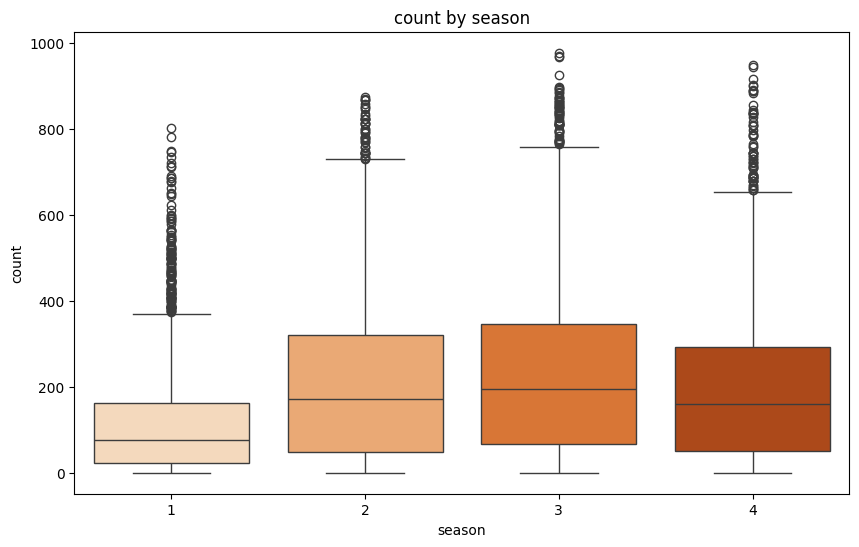

holiday      0    1    All
season                    
1         2615   71   2686
2         2685   48   2733
3         2637   96   2733
4         2638   96   2734
All      10575  311  10886
workingday     0     1    All
season                       
1            858  1828   2686
2            840  1893   2733
3            888  1845   2733
4            888  1846   2734
All         3474  7412  10886
Chi-Square Statistic: 49.158655596893624
P-value: 1.549925073686492e-07
The variables season and weather are dependent (reject H0).


In [ ]:
# Frequency distribution for the 'season' column
categorical_frequency(data, 'season');

# Visualize the distribution of 'season' using a bar plot
categorical_barplot(data, 'season', color_='Greens');

# Explore the relationship between 'season' and 'count' using a boxplot
categorical_vs_numerical_boxplot(data, 'season', 'count', color_='Oranges');

# Cross-tabulation of 'season' vs 'holiday'
categorical_crosstab(data, 'season', 'holiday');

# Cross-tabulation of 'season' vs 'workingday'
categorical_crosstab(data, 'season', 'workingday');

# Chi-Square test for 'season' and 'weather'
chi_square_test(data, 'season', 'weather');


holiday
0    10575
1      311
Name: count, dtype: int64

Percentage distribution:
holiday
0    97.14312
1     2.85688
Name: proportion, dtype: float64


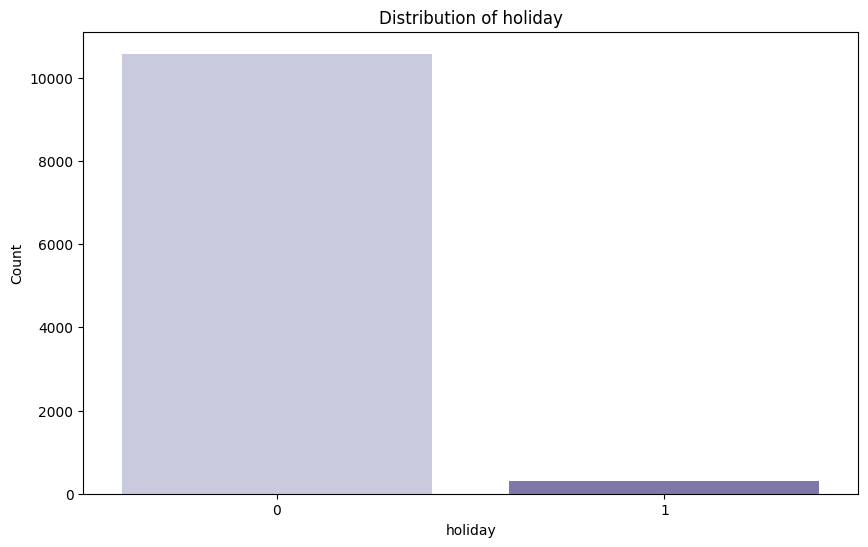

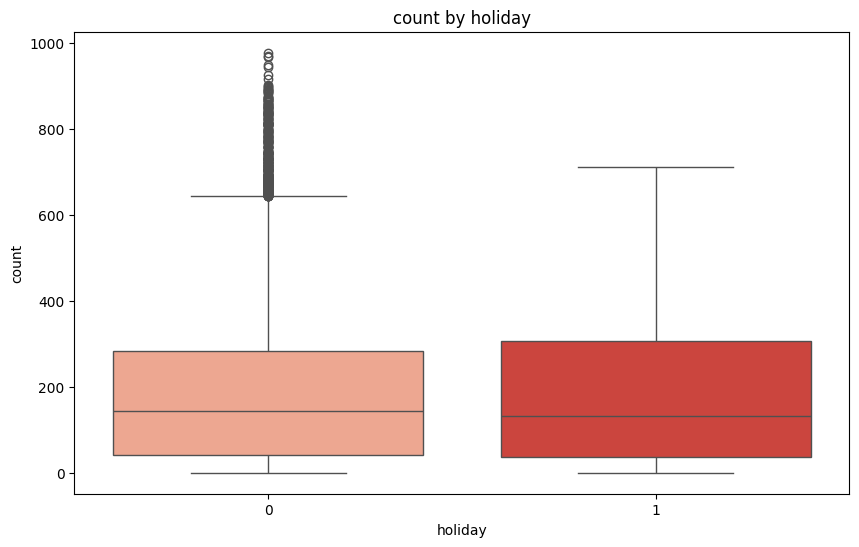

season      1     2     3     4    All
holiday                               
0        2615  2685  2637  2638  10575
1          71    48    96    96    311
All      2686  2733  2733  2734  10886
workingday     0     1    All
holiday                      
0           3163  7412  10575
1            311     0    311
All         3474  7412  10886
Chi-Square Statistic: 20.82338817816167
P-value: 0.00011455163312609901
The variables holiday and season are dependent (reject H0).


In [ ]:
# Frequency distribution for the 'holiday' column
categorical_frequency(data, 'holiday')

# Visualize the distribution of 'holiday' using a bar plot
categorical_barplot(data, 'holiday', color_='Purples')

# Explore the relationship between 'holiday' and 'count' using a boxplot
categorical_vs_numerical_boxplot(data, 'holiday', 'count', color_='Reds')

# Cross-tabulation of 'holiday' vs 'season'
categorical_crosstab(data, 'holiday', 'season')

# Cross-tabulation of 'holiday' vs 'workingday'
categorical_crosstab(data, 'holiday', 'workingday')

# Chi-Square test for 'holiday' and 'season'
chi_square_test(data, 'holiday', 'season')


workingday
1    7412
0    3474
Name: count, dtype: int64

Percentage distribution:
workingday
1    68.087452
0    31.912548
Name: proportion, dtype: float64


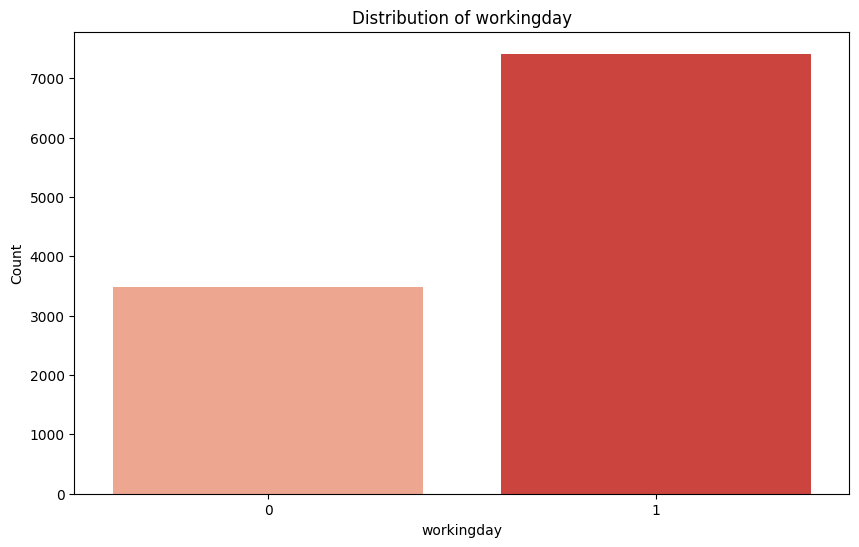

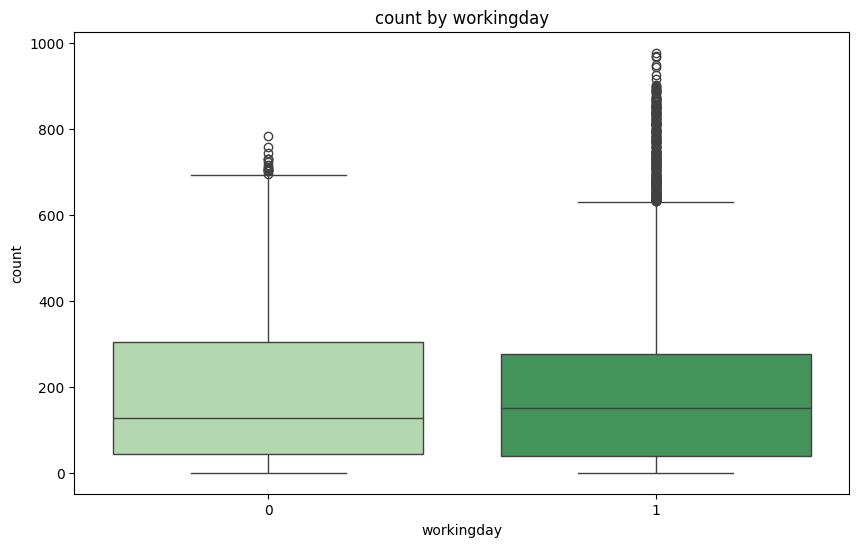

season         1     2     3     4    All
workingday                               
0            858   840   888   888   3474
1           1828  1893  1845  1846   7412
All         2686  2733  2733  2734  10886
holiday         0    1    All
workingday                   
0            3163  311   3474
1            7412    0   7412
All         10575  311  10886
Chi-Square Statistic: 679.8303606566715
P-value: 7.274717892533614e-150
The variables workingday and holiday are dependent (reject H0).


In [ ]:
# Frequency distribution for the 'workingday' column
categorical_frequency(data, 'workingday')

# Visualize the distribution of 'workingday' using a bar plot
categorical_barplot(data, 'workingday', color_='Reds')

# Explore the relationship between 'workingday' and 'count' using a boxplot
categorical_vs_numerical_boxplot(data, 'workingday', 'count', color_='Greens')

# Cross-tabulation of 'workingday' vs 'season'
categorical_crosstab(data, 'workingday', 'season')

# Cross-tabulation of 'workingday' vs 'holiday'
categorical_crosstab(data, 'workingday', 'holiday')

# Chi-Square test for 'workingday' and 'holiday'
chi_square_test(data, 'workingday', 'holiday')


weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64

Percentage distribution:
weather
1    66.066507
2    26.033437
3     7.890869
4     0.009186
Name: proportion, dtype: float64


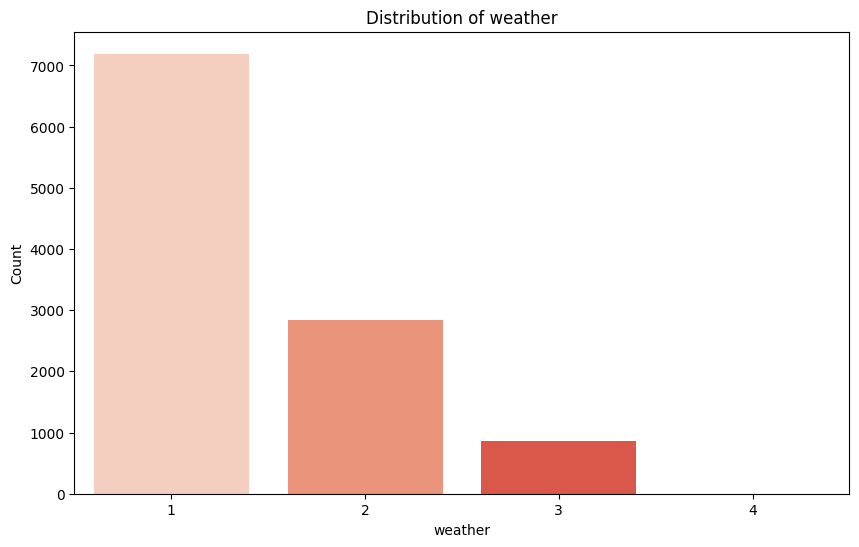

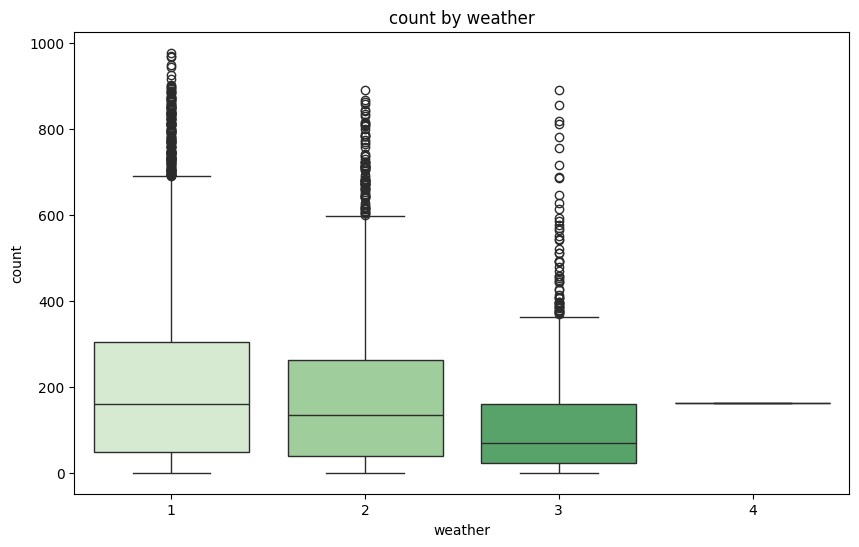

season      1     2     3     4    All
weather                               
1        1759  1801  1930  1702   7192
2         715   708   604   807   2834
3         211   224   199   225    859
4           1     0     0     0      1
All      2686  2733  2733  2734  10886
workingday     0     1    All
weather                      
1           2353  4839   7192
2            897  1937   2834
3            224   635    859
4              0     1      1
All         3474  7412  10886
Chi-Square Statistic: 49.15865559689363
P-value: 1.5499250736864862e-07
The variables weather and season are dependent (reject H0).


In [ ]:
# Frequency distribution for the 'weather' column
categorical_frequency(data, 'weather')

# Visualize the distribution of 'weather' using a bar plot
categorical_barplot(data, 'weather', color_='Reds')

# Explore the relationship between 'weather' and 'count' using a boxplot
categorical_vs_numerical_boxplot(data, 'weather', 'count', color_='Greens')

# Cross-tabulation of 'weather' vs 'season'
categorical_crosstab(data, 'weather', 'season')

# Cross-tabulation of 'weather' vs 'workingday'
categorical_crosstab(data, 'weather', 'workingday')

# Chi-Square test for 'weather' and 'season'
chi_square_test(data, 'weather', 'season')


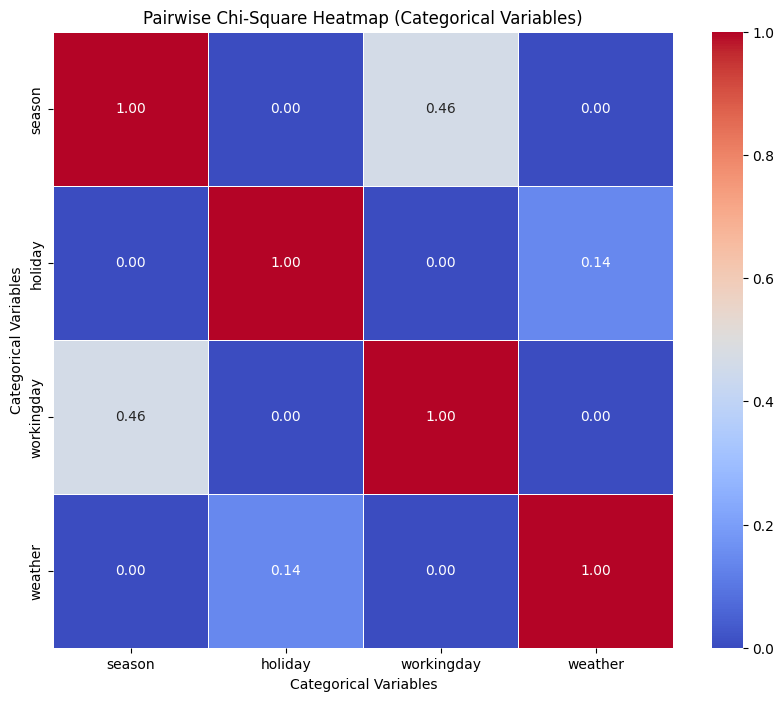

In [ ]:


# Categorical Heatmap:

# P-values close to 0 indicate statistically significant relationships.
# High p-values (e.g., > 0.05) suggest no significant association between the variables.

def categorical_chi_square_heatmap(data, categorical_columns):
    # Initialize a DataFrame to store p-values
    chi2_matrix = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))),
                               columns=categorical_columns, index=categorical_columns)

    # Perform pairwise chi-square tests
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                chi2_matrix.loc[col1, col2] = 1.0  # Perfect correlation
            else:
                contingency_table = pd.crosstab(data[col1], data[col2])
                _, p, _, _ = chi2_contingency(contingency_table)
                chi2_matrix.loc[col1, col2] = p

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(chi2_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Pairwise Chi-Square Heatmap (Categorical Variables)')
    plt.xlabel('Categorical Variables')
    plt.ylabel('Categorical Variables')
    plt.show()

# List of categorical columns
categorical_columns = ['season', 'holiday', 'workingday', 'weather']

# Call the function
categorical_chi_square_heatmap(data, categorical_columns)


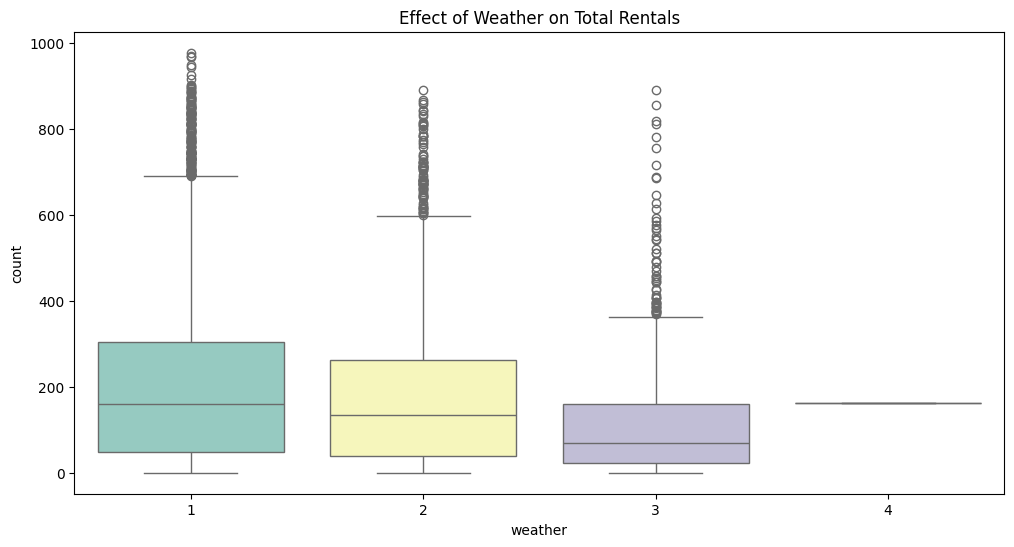

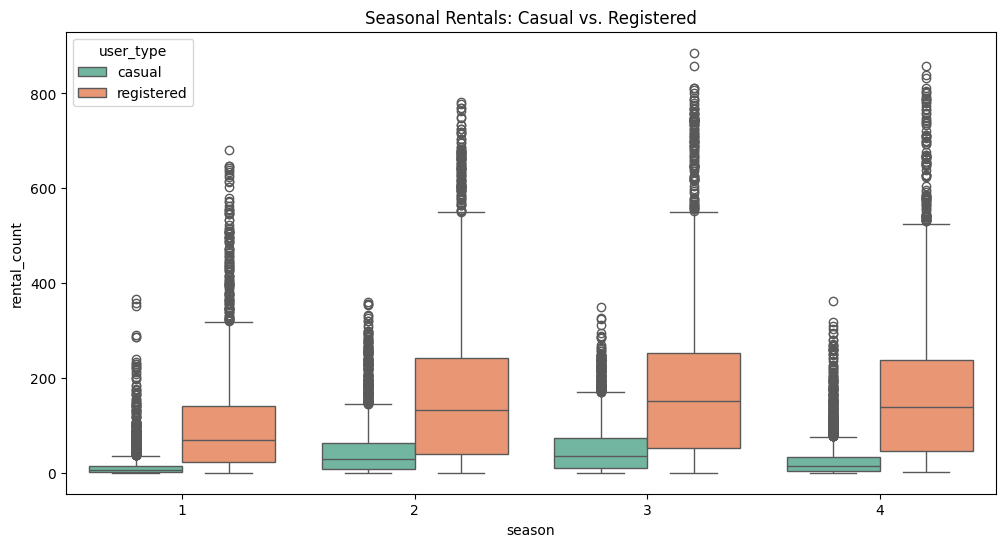

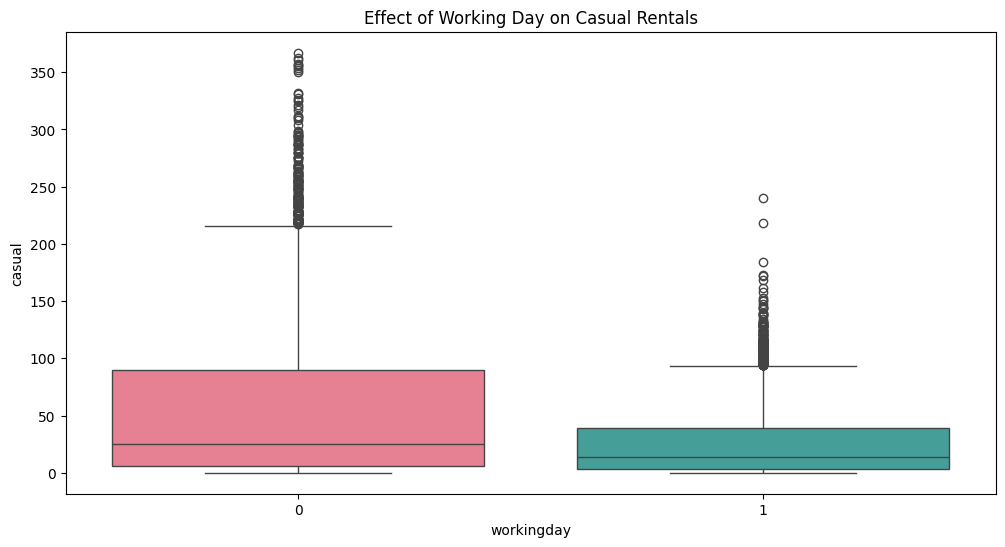

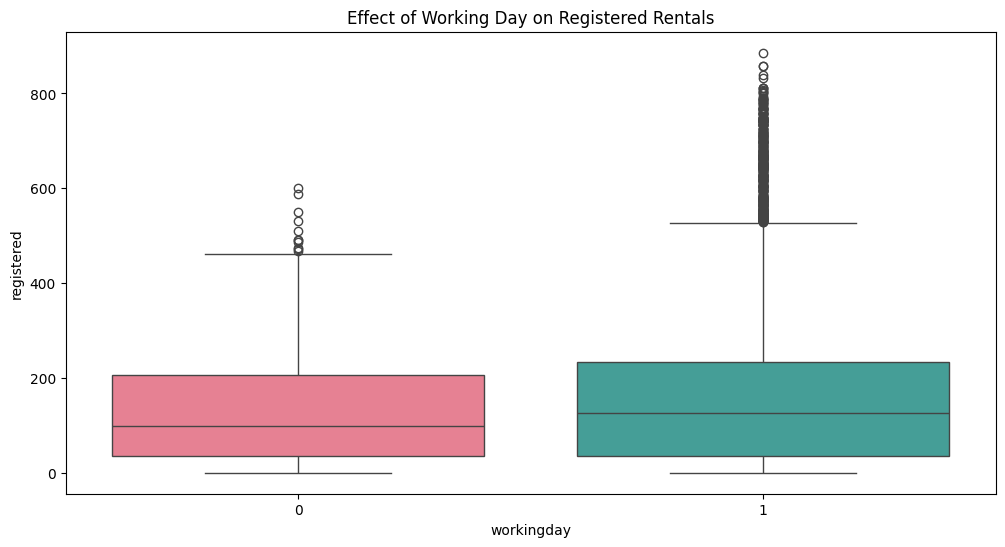

In [ ]:
# Effect of weather on rentals
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='count', data=data, palette='Set3')
plt.title('Effect of Weather on Total Rentals')
plt.show()


# Casual vs. registered rentals per season
plt.figure(figsize=(12, 6))
data_melted = data.melt(id_vars=['season'], value_vars=['casual', 'registered'],
                        var_name='user_type', value_name='rental_count')
sns.boxplot(x='season', y='rental_count', hue='user_type', data=data_melted, palette='Set2')
plt.title('Seasonal Rentals: Casual vs. Registered')
plt.show()

# Effect of workingday on casual and registered rentals
plt.figure(figsize=(12, 6))
sns.boxplot(x='workingday', y='casual', data=data, palette='husl')
plt.title('Effect of Working Day on Casual Rentals')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='workingday', y='registered', data=data, palette='husl')
plt.title('Effect of Working Day on Registered Rentals')
plt.show()

#### Exploring TimeSeries

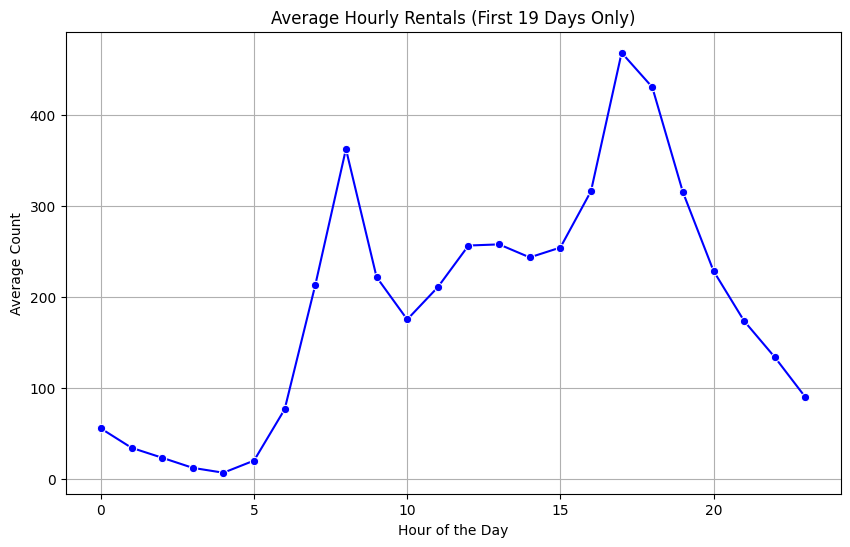

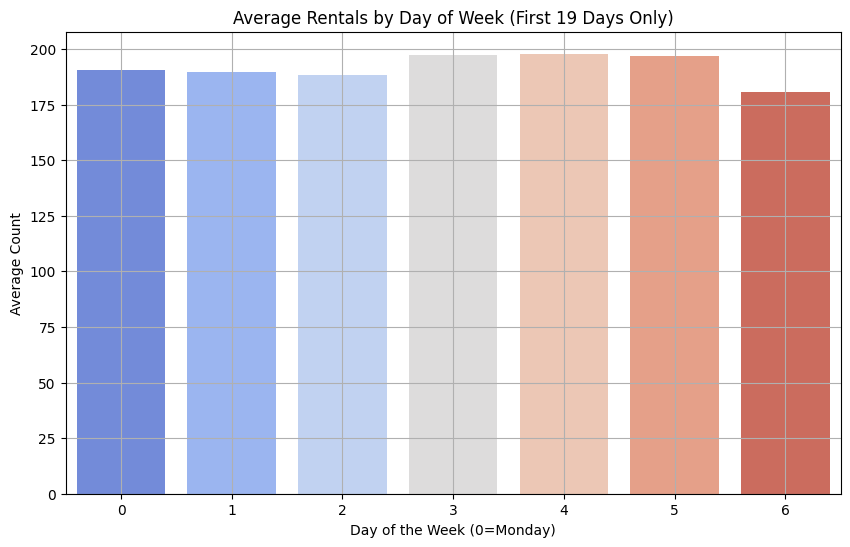

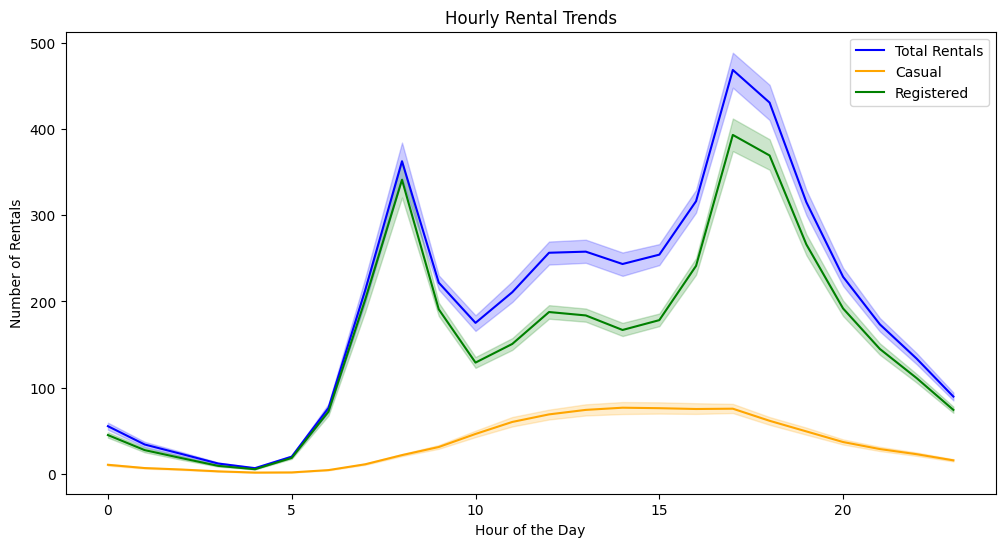

In [ ]:
# Group by hour for average rentals
hourly_trend = data.groupby('hour')['count'].mean()

# Plot hourly pattern
plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_trend.index, y=hourly_trend.values, marker='o', color='blue')
plt.title('Average Hourly Rentals (First 19 Days Only)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Count')
plt.grid()
plt.show()

# Group by day of the week for average rentals
daily_trend = data.groupby('day_of_week')['count'].mean()

# Plot daily pattern
plt.figure(figsize=(10, 6))
sns.barplot(x=daily_trend.index, y=daily_trend.values, palette='coolwarm')
plt.title('Average Rentals by Day of Week (First 19 Days Only)')
plt.xlabel('Day of the Week (0=Monday)')
plt.ylabel('Average Count')
plt.grid()
plt.show()


# Hourly trends of rentals
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='count', data=data, label='Total Rentals', color='blue')
sns.lineplot(x='hour', y='casual', data=data, label='Casual', color='orange')
sns.lineplot(x='hour', y='registered', data=data, label='Registered', color='green')
plt.title('Hourly Rental Trends')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()


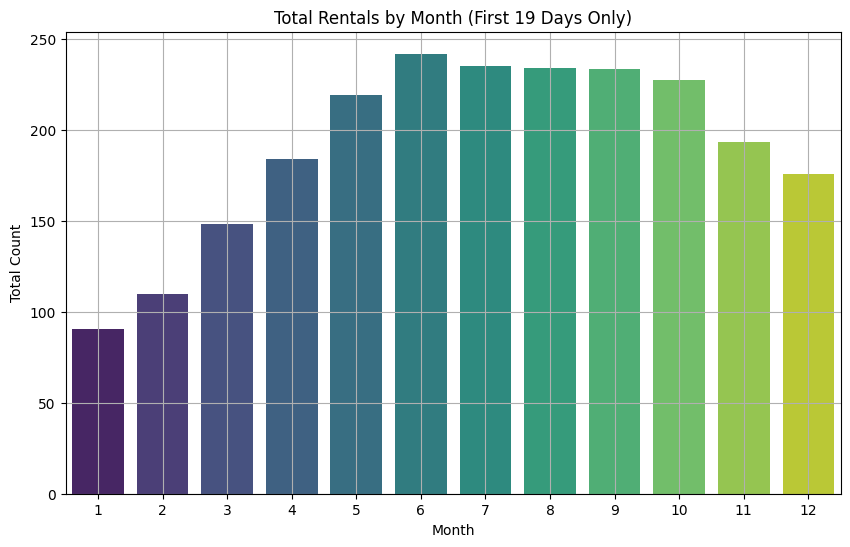

In [ ]:
# Group by month for total rentals
monthly_trend = data.groupby('month')['count'].mean()

# Plot monthly trend
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_trend.index, y=monthly_trend.values, palette='viridis')
plt.title('Total Rentals by Month (First 19 Days Only)')
plt.xlabel('Month')
plt.ylabel('Total Count')
plt.grid()
plt.show()


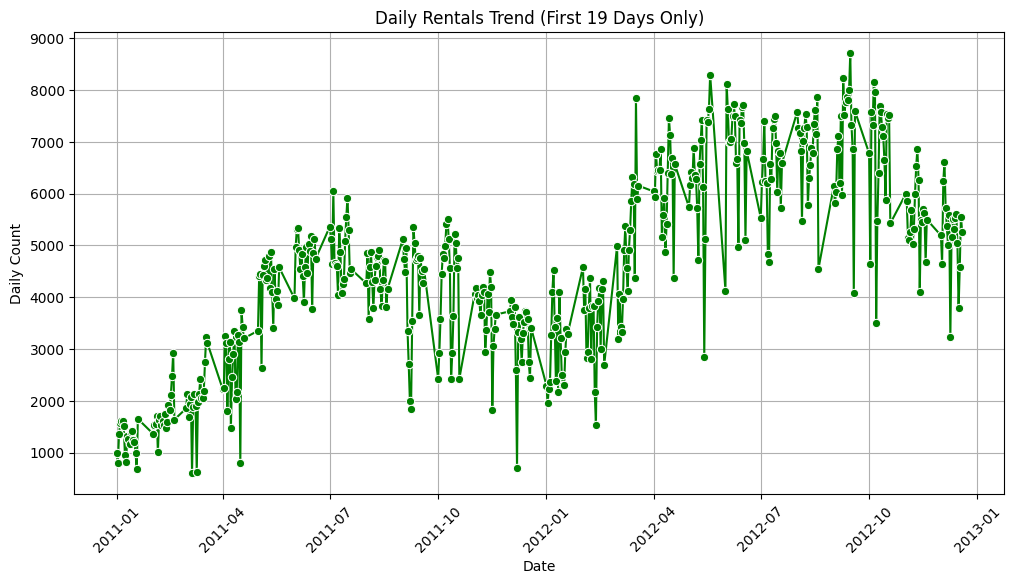

In [ ]:
# Aggregate by day within each month
daily_rentals = data.groupby(data['datetime'].dt.date)['count'].sum()

# Plot daily trend for available data
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_rentals.index, y=daily_rentals.values, marker='o', color='green')
plt.title('Daily Rentals Trend (First 19 Days Only)')
plt.xlabel('Date')
plt.ylabel('Daily Count')
plt.xticks(rotation=45)
plt.grid()
plt.show()


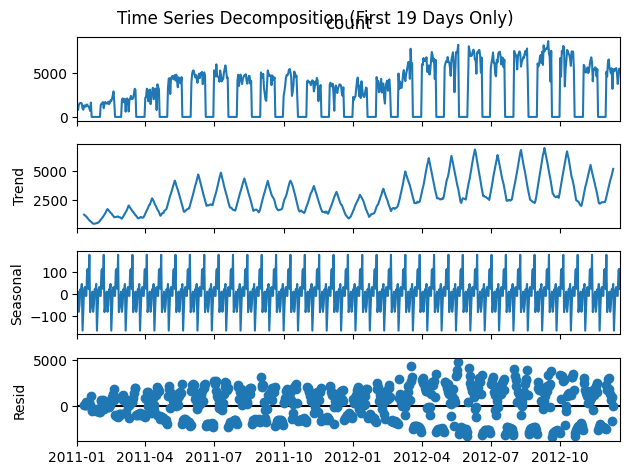

In [ ]:


# Resample to daily granularity
partial_daily_data = data.resample('D', on='datetime').sum()

# Perform decomposition
decomposition = seasonal_decompose(partial_daily_data['count'], model='additive', period=19)

# Plot decomposition
decomposition.plot()
plt.suptitle('Time Series Decomposition (First 19 Days Only)', fontsize=12)
plt.show()


### Feature Engineering

In [ ]:
# for Transformation
data_transform = data.copy()

data_transform.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'day_of_week', 'hour'],
      dtype='object')

#### Time-Based Features

In [ ]:

#Weekend Indicator: Create a feature to indicate whether the day is a weekend.
data_transform['is_weekend'] =  data_transform['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


#Part of Day: Group hours into categories like morning, afternoon, evening, and night.
def part_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

data_transform['part_of_day'] =  data_transform['hour'].apply(part_of_day)


# Year-Month Combination: Combine year and month for monthly trend analysis.
data_transform['year_month'] =  data_transform['year'].astype(str) + '-' + data_transform['month'].astype(str).str.zfill(2)

# Seasonality Encoding: Convert the season column into one-hot encoding for season-based analysis.
# season_dummies = pd.get_dummies(data_transform['season'], prefix='season')
# data_transform = pd.concat([data_transform, season_dummies], axis=1)

# season_dummies = pd.get_dummies(data_transform['season'], prefix='season', dtype=int)
# data_transform = pd.concat([data_transform, season_dummies], axis=1)

#Time-Based Features Quarter: Add a feature for the quarter of the year (Q1, Q2, Q3, Q4). Helps capture seasonality trends tied to specific quarters.
data_transform['quarter'] = data_transform['month'].apply(lambda x: (x-1)//3 + 1)

# Day Type: Create a feature that categorizes days as weekday, weekend, or holiday. Helps in separating different behavioral patterns for rentals.
# data_transform['day_type'] = np.where(data_transform['holiday'] == 1, 'Holiday', np.where(data_transform['is_weekend'], 'Weekend', 'Weekday')

data_transform['day_type'] = data_transform['is_weekend'].astype(str) + '_' + data_transform['holiday'].astype(str)

# Peak/Off-Peak Hours: Create a binary feature indicating whether a given hour is in the peak (commute times) or off-peak hours.
def peak_hours(hour):
    return 1 if (7 <= hour <= 9 or 17 <= hour <= 19) else 0
data_transform['is_peak_hour'] = data_transform['hour'].apply(peak_hours)


#### Weather-Based Features

In [ ]:
#Feels Like Difference: Capture the difference between actual temperature and "feels like" temperature. This could help identify discomfort levels in weather.
data_transform['feels_like_temp_diff'] = abs(data_transform['temp'] - data_transform['atemp'])

# Humidity Level:Group humidity into levels (e.g., low, medium, high).
def humidity_level(humidity):
    if humidity < 30:
        return 'Low'
    elif 30 <= humidity <= 70:
        return 'Medium'
    else:
        return 'High'

data_transform['humidity_level'] = data_transform['humidity'].apply(humidity_level)

# Define windspeed levels
def windspeed_level(windspeed):
    if windspeed <= 11:
        return 'Calm'
    elif 12 <= windspeed <= 28:
        return 'Breezy'
    else:
        return 'Windy'

data_transform['windspeed_level'] = data_transform['windspeed'].apply(windspeed_level)


# Define temperature levels
def temp_level(temp):
    if temp < 10:
        return 'Cold'
    elif 10 <= temp <= 25:
        return 'Moderate'
    else:
        return 'Hot'

data_transform['temp_level'] = data_transform['temp'].apply(temp_level)


# Define atemp levels
def atemp_level(atemp):
    if atemp < 10:
        return 'Cold'
    elif 10 <= atemp <= 25:
        return 'Moderate'
    else:
        return 'Hot'

data_transform['atemp_level'] = data_transform['atemp'].apply(atemp_level)


# Extreme Weather: Flag extreme weather conditions (e.g., high humidity + high temperature or severe weather categories).
data_transform['extreme_weather'] = np.where((data_transform['humidity'] > 80) & (data_transform['temp'] > 30), 1, 0)

# # Weather Type Encoding: Convert weather into one-hot encoding or ordinal features.
# weather_dummies = pd.get_dummies(data_transform['weather'], prefix='weather', dtype=int)
# data_transform = pd.concat([data_transform, weather_dummies], axis=1)

#### Interactive Features

In [ ]:
# Weekend and Weather Interaction: Highlight how weekends interact with weather conditions.
data_transform['weekend_weather'] = data_transform['is_weekend'].astype(str) + '_' + data_transform['weather'].astype(str)




# Temperature & Weather Interaction: Interaction term combining weather condition and temperature level to capture how extreme weather affects rentals.
data_transform['temp_weather'] = data_transform['temp_level'].astype(str) + '_' + data_transform['weather'].astype(str)

# Humidity & Weather Interaction: Interaction term combining weather condition and humidity level to capture how extreme weather affects rentals.
data_transform['humidity_weather'] = data_transform['humidity_level'].astype(str) + '_' + data_transform['weather'].astype(str)

# Windspeed & Weather Interaction: Interaction term combining weather condition and windspeed level to capture how extreme weather affects rentals.
data_transform['windspeed_weather'] = data_transform['windspeed_level'].astype(str) + '_' + data_transform['weather'].astype(str)

# atemp & Weather Interaction: Interaction term combining weather condition and perceived temperature level to capture how extreme weather affects rentals.
data_transform['atemp_weather'] = data_transform['atemp_level'].astype(str) + '_' + data_transform['weather'].astype(str)




# Holiday & Hour Interaction: Interaction term for holidays and specific hours to capture holiday-specific rental trends.
data_transform['holiday_hour'] = data_transform['holiday'].astype(str) + '_' + data_transform['part_of_day'].astype(str)

# Holiday and Weather Interaction: Combine working day and weather to study their combined effects.
data_transform['holiday_weather'] = data_transform['holiday'].astype(str) + '_' + data_transform['weather'].astype(str)


# workingday & Hour Interaction: Interaction term for workingday and specific hours to capture holiday-specific rental trends.
data_transform['workingday_hour'] = data_transform['workingday'].astype(str) + '_' + data_transform['part_of_day'].astype(str)

# workingday and Weather Interaction: Combine working day and weather to study their combined effects.
data_transform['workingday_weather'] = data_transform['workingday'].astype(str) + '_' + data_transform['weather'].astype(str)


# Season and Hour Interaction: Capture seasonal variation in hourly rentals.
data_transform['season_hour'] = data_transform['season'].astype(str) + '_' + data_transform['part_of_day'].astype(str)

# Season & Working Day: Interaction term to capture seasonality patterns on working days.
data_transform['season_workingday'] = data_transform['season'].astype(str) + '_' + data_transform['workingday'].astype(str)

# Season & holiday: Interaction term to capture seasonality patterns on working days.
data_transform['season_holiday'] = data_transform['season'].astype(str) + '_' + data_transform['holiday'].astype(str)

# Season & Weather: Interaction term to capture seasonality patterns on working days.
data_transform['season_weather'] = data_transform['season'].astype(str) + '_' + data_transform['weather'].astype(str)




#### Rental Ratios

In [ ]:
# Casual to Registered User Ratio: Analyze the proportion of casual users to registered users.
data_transform['casual_registered_ratio'] = data_transform['casual'] / (data_transform['registered'] + 1e-6)  # Avoid division by zero

# Registered to Total Rentals Ratio: Determine the contribution of registered users to total rentals.
data_transform['registered_ratio'] = data_transform['registered'] / data_transform['count']

# Casual to Total Rentals Ratio: Determine the contribution of registered users to total rentals.
data_transform['registered_ratio'] = data_transform['registered'] / data_transform['count']


#### Aggregated Features

In [ ]:

# Rolling Averages: Compute rolling averages for rentals over time.
data_transform['count_rolling_mean_3'] = data_transform['count'].rolling(window=3).mean()

# Lag Features: Include lagged rentals as predictors.
data_transform['count_lag_1'] = data_transform['count'].shift(1)
data_transform['count_lag_2'] = data_transform['count'].shift(2)

# Cumulative Rentals: Analyze cumulative rentals up to a specific point.
data_transform['cumulative_count'] = data_transform['count'].cumsum()

# Hourly Rolling Metrics by Season: Add rolling statistics (mean, std) for the count, casual, and registered rentals grouped by season or weather.
data_transform['rolling_mean_12h'] = data_transform.groupby('season')['count'].transform(lambda x: x.rolling(12).mean())

# Difference from Rolling Mean: Feature to measure how a current observation deviates from the rolling average.
data_transform['diff_from_rolling_mean'] = data_transform['count'] - data_transform['count_rolling_mean_3']

# Cumulative Rentals by Season: Track cumulative rentals over time for each season.
data_transform['cumulative_season_count'] = data_transform.groupby('season')['count'].cumsum()

# Growth Rate: Calculate the rate of increase/decrease in rental counts compared to previous periods.
data_transform['growth_rate'] = data_transform['count'].pct_change()



#### Clustering Features

In [ ]:
# 1. Customer Segments Clustering
# We'll group the data based on rental count and other relevant features, like casual, registered, and count.

# Select relevant features for customer segmentation
customer_features = data_transform[['casual', 'registered']]

# Normalize the data (optional, but often recommended for clustering)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features)

# Perform KMeans clustering (e.g., 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
data_transform['customer_segment'] = kmeans.fit_predict(customer_features_scaled)

# Check the resulting customer segments
print(data_transform[['casual', 'registered', 'customer_segment']].head())


# # Plot customer segments (2D visualization, using 'casual' and 'count' for simplicity)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=data_transform, x='casual', y='registered', hue='customer_segment', palette='Set1', s=100)
# plt.title('Customer Segments Based on Rentals')
# plt.xlabel('Casual Rentals')
# plt.ylabel('Total Rentals')
# plt.legend(title='Customer Segment')
# plt.show()



   casual  registered  customer_segment
0       3          13                 0
1       8          32                 0
2       5          27                 0
3       3          10                 0
4       0           1                 0


In [ ]:
# 2. Weather-Based Clusters
# We'll group data based on weather conditions (temp, humidity, and windspeed).

# Select relevant features for weather clustering
weather_features = data_transform[['temp', 'humidity', 'windspeed', 'season']]

# Normalize the data
weather_features_scaled = scaler.fit_transform(weather_features)

# Perform KMeans clustering (e.g., 4 clusters)
kmeans_weather = KMeans(n_clusters=4, random_state=42)
data_transform['weather_cluster'] = kmeans_weather.fit_predict(weather_features_scaled)

# Check the resulting weather clusters
print(data_transform[['temp', 'humidity', 'windspeed', 'season', 'weather_cluster']].head())

# # Plot weather clusters (2D visualization, using 'temp' and 'humidity' for simplicity)
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=data_transform, x='temp', y='humidity', hue='weather_cluster', palette='Set2', s=100)
# plt.title('Weather Clusters Based on Temperature and Humidity')
# plt.xlabel('Temperature')
# plt.ylabel('Humidity')
# plt.legend(title='Weather Cluster')
# plt.show()


   temp  humidity  windspeed  season  weather_cluster
0  9.84        81        0.0       1                2
1  9.02        80        0.0       1                2
2  9.02        80        0.0       1                2
3  9.84        75        0.0       1                2
4  9.84        75        0.0       1                2


In [ ]:
data_transform.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'day_of_week', 'hour', 'is_weekend',
       'part_of_day', 'year_month', 'quarter', 'day_type', 'is_peak_hour',
       'feels_like_temp_diff', 'humidity_level', 'windspeed_level',
       'temp_level', 'atemp_level', 'extreme_weather', 'weekend_weather',
       'temp_weather', 'humidity_weather', 'windspeed_weather',
       'atemp_weather', 'holiday_hour', 'holiday_weather', 'workingday_hour',
       'workingday_weather', 'season_hour', 'season_workingday',
       'season_holiday', 'season_weather', 'casual_registered_ratio',
       'registered_ratio', 'count_rolling_mean_3', 'count_lag_1',
       'count_lag_2', 'cumulative_count', 'rolling_mean_12h',
       'diff_from_rolling_mean', 'cumulative_season_count', 'growth_rate',
       'customer_segment', 'weather_cluster'],
      dtype='object')

In [ ]:
data_transform.shape

(10886, 54)

In [ ]:
data_transform.to_csv('data_transform.csv', index=False)

### Feature Importance



#### Information Value and Weight of Evidence

In [ ]:
# Load your dataset
data_information_value = data_transform.copy()


In [ ]:


# Load your dataset
data_information_value = data_transform.copy()

# Specify the target variable
target = 'count'

# Create a binary target variable based on the median
median_count = data_information_value[target].median()
data_information_value['count_binned'] = (data_information_value[target] > median_count).astype(int)

# Drop unnecessary columns (e.g., `datetime` and original `count`)
data_information_value = data_information_value.drop(columns=['datetime', 'count'])

# Identify and remove columns with too many unique non-numeric values
max_unique_threshold = 50  # Set an appropriate threshold
too_many_uniques = [col for col in data_information_value.columns
                    if data_information_value[col].dtype == 'object' and data_information_value[col].nunique() > max_unique_threshold]

# Drop problematic columns
if too_many_uniques:
    print(f"Columns with too many unique non-numeric values: {too_many_uniques}")
    data_information_value = data_information_value.drop(columns=too_many_uniques)

# Perform WOE binning for all predictors
bins = sc.woebin(data_information_value, y='count_binned')

# Calculate IV for each variable
iv_values = pd.DataFrame({
    'variable': [key for key in bins.keys()],
    'total_iv': [bin_table['total_iv'].iloc[0] for bin_table in bins.values()]
})

# Sort IV values in descending order
iv_values = iv_values.sort_values(by='total_iv', ascending=False)
print("IV Summary:")
print(iv_values)

# Display binning results for each variable
for var, bin_table in bins.items():
    print(f"Variable: {var}")
    print(bin_table[['variable', 'bin', 'woe']])  # Display valid columns
    print('-' * 40)

# Select features with IV > 0.02
selected_features = iv_values[iv_values['total_iv'] > 0.02]['variable'].tolist()
print("Selected Features for Modeling:")
print(selected_features)


[INFO] creating woe binning ...
Binning on 10886 rows and 51 columns in 00:00:21
IV Summary:
                   variable   total_iv
38               registered  11.877669
15         customer_segment   6.680971
23              count_lag_1   5.557028
47     count_rolling_mean_3   5.119591
35                   casual   4.542362
45          workingday_hour   3.287380
31              season_hour   3.137274
30                     hour   2.874626
33              part_of_day   2.695364
43             holiday_hour   2.695364
28              count_lag_2   2.184418
7    diff_from_rolling_mean   1.833927
36         registered_ratio   1.307476
32              growth_rate   1.127225
20          weather_cluster   0.831514
18                     temp   0.753169
16                    atemp   0.740814
27             temp_weather   0.597169
41         rolling_mean_12h   0.564409
24            atemp_weather   0.538190
8                temp_level   0.530725
25             is_peak_hour   0.513278
14        

In [ ]:
len(selected_features)

44

In [ ]:
df = data_transform.copy()

In [ ]:
# Numerical Features
numerical_features = [
    'registered', 'casual', 'registered_ratio', 'temp', 'atemp',
    'cumulative_count',  'casual_registered_ratio', 'humidity', 'cumulative_season_count',
     'feels_like_temp_diff', 'windspeed'
]

# Categorical Features
categorical_features = [
    'customer_segment', 'workingday_hour', 'season_hour', 'hour', 'holiday_hour', 'part_of_day', 'weather_cluster',
    'is_peak_hour', 'season_weather', 'humidity_weather', 'season_holiday', 'season_workingday', 'season',
    'quarter', 'year', 'windspeed_weather', 'workingday_weather', 'weekend_weather', 'holiday_weather', 'weather',
    'atemp_level', 'temp_level', 'temp_weather', 'atemp_weather', 'humidity_level', 'month', 'windspeed_level'
]

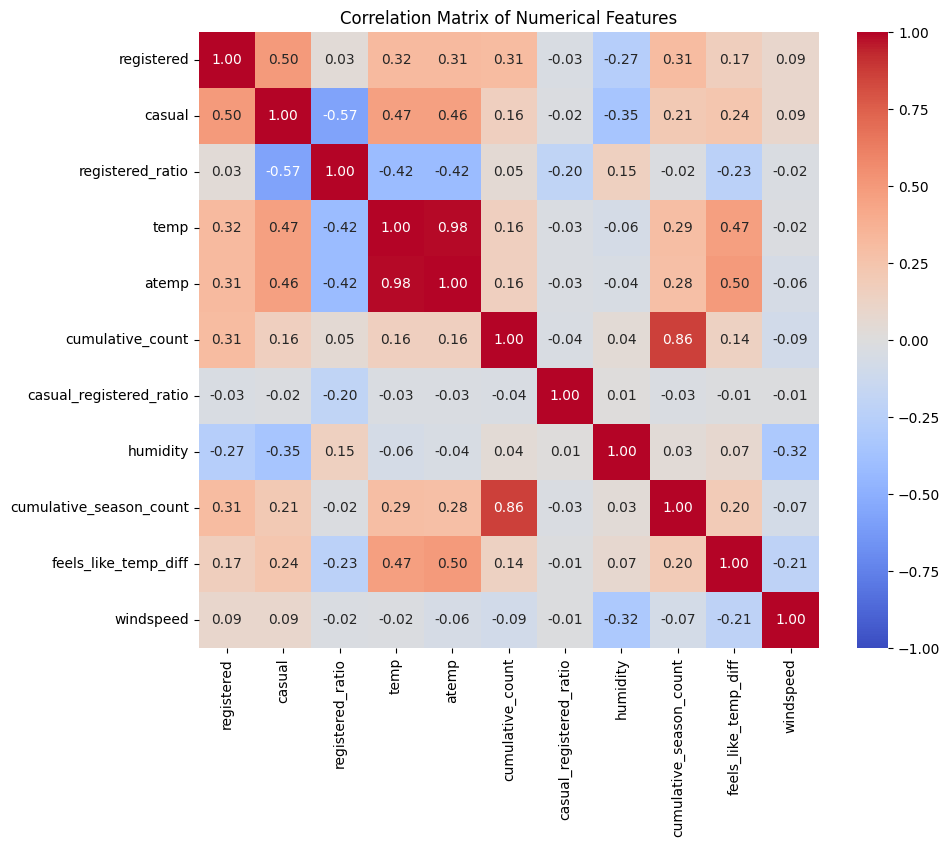

Highly correlated features: {'temp', 'atemp'}
Reduced numerical features: ['registered', 'casual', 'registered_ratio', 'cumulative_count', 'casual_registered_ratio', 'humidity', 'cumulative_season_count', 'feels_like_temp_diff', 'windspeed']


In [ ]:

# Calculate the correlation matrix for numerical features
corr_matrix = df[numerical_features].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Remove features with high correlation (e.g., > 0.9)
threshold = 0.9
# Find pairs of features that have a correlation greater than the threshold
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_features.add(corr_matrix.columns[i])
            high_corr_features.add(corr_matrix.columns[j])

print("Highly correlated features:", high_corr_features)

# Drop the features with high correlation if needed
reduced_numerical_features = [f for f in numerical_features if f not in high_corr_features]
print("Reduced numerical features:", reduced_numerical_features)


#### Predcitive Modelling - Random Forest Feature Importance


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Load the dataset (replace 'data.csv' with the correct path if needed)
df = data_transform.copy()


# Convert 'datetime' to pandas datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort data by datetime to ensure chronological order
df = df.sort_values(by='datetime')


target = 'count'

# Split data based on time
train_end_date = df['datetime'].quantile(0.75)  # 75% for training, adjust as needed
validation_end_date = df['datetime'].quantile(0.875)  # 87.5% for training + validation
test_end_date = df['datetime'].max()  # Test on the most recent period

# Split into train, validation, and test sets based on datetime
train_data = df[df['datetime'] <= train_end_date]
validation_data = df[(df['datetime'] > train_end_date) & (df['datetime'] <= validation_end_date)]
test_data = df[df['datetime'] > validation_end_date]

# Features and target variable for train, validation, and test
X_train = train_data[selected_features]
y_train = train_data[target]

X_validation = validation_data[selected_features]
y_validation = validation_data[target]

X_test = test_data[selected_features]
y_test = test_data[target]

# # Define numerical and categorical features based on the selected features

# Numerical Features
numerical_features = [
    'registered', 'casual', 'registered_ratio', 'temp', 'cumulative_count',
    'casual_registered_ratio', 'humidity', 'cumulative_season_count',
     'feels_like_temp_diff', 'windspeed'
]

# Categorical Features
categorical_features = [
    'customer_segment', 'workingday_hour', 'season_hour', 'hour', 'holiday_hour', 'part_of_day', 'weather_cluster',
    'is_peak_hour', 'season_weather', 'humidity_weather', 'season_holiday', 'season_workingday', 'season',
    'quarter', 'year', 'windspeed_weather', 'workingday_weather', 'weekend_weather', 'holiday_weather', 'weather',
    'atemp_level', 'temp_level', 'temp_weather', 'atemp_weather', 'humidity_level', 'month', 'windspeed_level'
]


# Preprocessing pipeline: handle numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the model pipeline: Using Random Forest Regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))  # You can switch this to LinearRegression() for a different approach
])

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = model.predict(X_validation)

# Make predictions on the test set
y_test_pred = model.predict(X_test)


# Model evaluation
mae_val = mean_absolute_error(y_validation, y_val_pred)

# calculate RMSE
rmse_val = mean_squared_error(y_validation, y_val_pred)**0.5

r2_val = r2_score(y_validation, y_val_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)

# calculate RMSE for the test set
rmse_test = mean_squared_error(y_test, y_test_pred)**0.5

r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Validation Set Evaluation:")
print(f"Mean Absolute Error: {mae_val}")
print(f"Root Mean Squared Error: {rmse_val}")
print(f"R-squared: {r2_val}")

print(f"\nTest Set Evaluation:")
print(f"Mean Absolute Error: {mae_test}")
print(f"Root Mean Squared Error: {rmse_test}")
print(f"R-squared: {r2_test}")


Validation Set Evaluation:
Mean Absolute Error: 3.974070536370316
Root Mean Squared Error: 11.057104395125446
R-squared: 0.9976174669794491

Test Set Evaluation:
Mean Absolute Error: 3.451440117560617
Root Mean Squared Error: 9.052506064862468
R-squared: 0.998027877552424


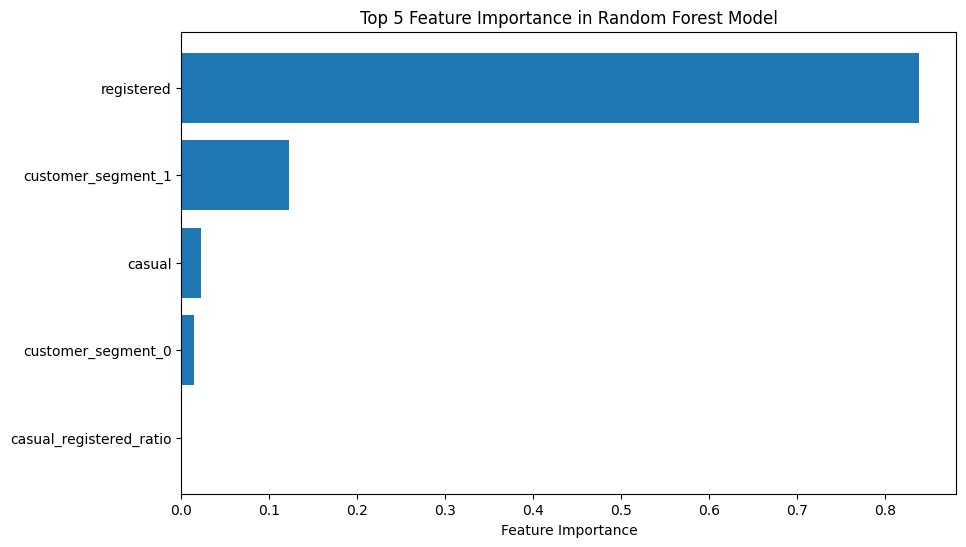

                    Feature  Importance
0                registered    0.838723
11       customer_segment_1    0.122158
1                    casual    0.022562
10       customer_segment_0    0.014249
5   casual_registered_ratio    0.000616


In [ ]:


# Get feature importance from the trained model
importances = model.named_steps['regressor'].feature_importances_

# Get the feature names
num_features = numerical_features
cat_features = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)

# Combine numerical and categorical feature names
all_feature_names = np.concatenate([num_features, cat_features])

# Create a dataframe for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Filter out features with zero importance
feature_importance_df_non_zero = feature_importance_df[feature_importance_df['Importance'] > 0]

# Sort the feature importance in descending order and select the top 5 features
top_5_features = feature_importance_df_non_zero.sort_values(by='Importance', ascending=False).head(5)

# Plot the top 5 most important features
plt.figure(figsize=(10, 6))
plt.barh(top_5_features['Feature'], top_5_features['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 5 Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

# Print the top 7 feature importance
print(top_5_features)


In [ ]:
# -------------------

### Forecasting

#### Random Forest Forecast

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assume data_transform is the loaded dataset
df = data_transform.copy()

# Ensure 'datetime' is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')

# Select predictors and target
numerical_features = ['registered_ratio', 'temp', 'cumulative_count',
    'casual_registered_ratio', 'humidity', 'cumulative_season_count',
    'feels_like_temp_diff', 'windspeed']
categorical_features = [
    'customer_segment', 'workingday_hour', 'season_hour', 'hour', 'holiday_hour', 'part_of_day', 'weather_cluster',
    'is_peak_hour', 'season_weather', 'humidity_weather', 'season_holiday', 'season_workingday', 'season',
    'quarter', 'year', 'windspeed_weather', 'workingday_weather', 'weekend_weather', 'holiday_weather', 'weather',
    'atemp_level', 'temp_level', 'temp_weather', 'atemp_weather', 'humidity_level', 'month', 'windspeed_level'
]
features = numerical_features + categorical_features
target = ['registered', 'casual']

# Define forecast horizon (7 days of hourly data)
forecast_horizon = 7 * 24

# Prepare historical lags
lag_steps = 24  # Use the last 24 hours as features
for lag in range(1, lag_steps + 1):
    for col in target:
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)

# Drop rows with NaN values after lagging
df = df.dropna()

# Split the dataset
train_data = df[df['datetime'] <= df['datetime'].max() - pd.Timedelta(days=7)]
test_data = df[df['datetime'] > df['datetime'].max() - pd.Timedelta(days=7)]

X_train = train_data[features + [f"{col}_lag_{lag}" for lag in range(1, lag_steps + 1) for col in target]]
y_train = train_data[target]

X_test = test_data[features + [f"{col}_lag_{lag}" for lag in range(1, lag_steps + 1) for col in target]]
y_test = test_data[target]

# Preprocessing
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict future values
y_test_pred = model_pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_test_pred)

print("\nModel Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared: {r2}")

In [ ]:
# Start from the last known data point
forecast_input = test_data.iloc[-1][features].copy()  # Initialize with the last row of test_data
forecast_input['datetime'] = test_data['datetime'].iloc[-1]  # Include datetime for tracking
forecast_results = []

for step in range(forecast_horizon):
    # Prepare input for the pipeline (exclude datetime for prediction)
    forecast_input_df = forecast_input.drop('datetime').to_frame().T

    # Predict using the pipeline
    forecast = model_pipeline.predict(forecast_input_df)
    forecast_registered = forecast[0][0]
    forecast_casual = forecast[0][1]

    # Append the forecasted results
    forecast_results.append({
        'registered': forecast_registered,
        'casual': forecast_casual,
        'datetime': forecast_input['datetime'] + pd.Timedelta(hours=step + 1)
    })

    # Update the input for the next prediction
    forecast_input['registered'] = forecast_registered
    forecast_input['casual'] = forecast_casual
    forecast_input['datetime'] += pd.Timedelta(hours=1)

    # Update lag features
    for lag in range(1, lag_steps + 1):
        forecast_input[f'registered_lag_{lag}'] = forecast_registered
        forecast_input[f'casual_lag_{lag}'] = forecast_casual

    # Recalculate rolling features (example: rolling mean over the past 3 hours)
    rolling_window = 3
    forecast_input['count_rolling_mean_3'] = (
        pd.Series([forecast_registered for _ in range(rolling_window)])
        .rolling(window=rolling_window, min_periods=1)
        .mean()
        .iloc[-1]
    )

forecast_df = pd.DataFrame(forecast_results)

# print("\nForecasted Values:")
# print(forecast_df)


#### LSTM Forecast

Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0148 - val_loss: 0.0109
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0078 - val_loss: 0.0084
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 8/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 9/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 10/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 11/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 12/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s

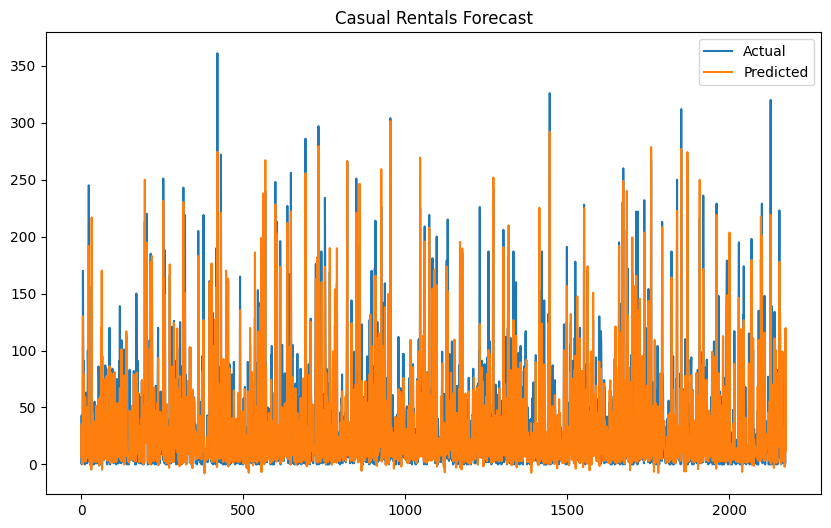

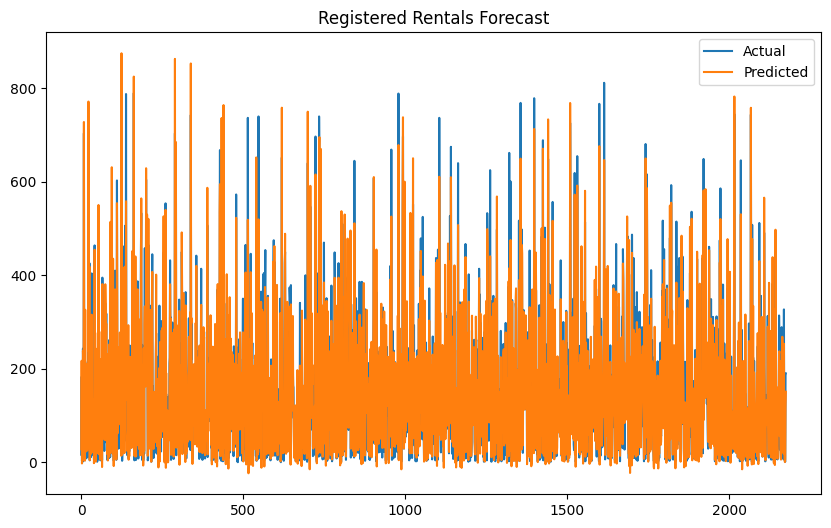

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("exploratory_data_analysis.csv", parse_dates=['datetime'])
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.day
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year

# Feature engineering and lag features
data['lag_1'] = data['count'].shift(1)
data['lag_2'] = data['count'].shift(2)
data['rolling_mean_3'] = data['count'].rolling(window=3).mean()
data = data.dropna()

# Selecting features
features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year', 'lag_1', 'lag_2', 'rolling_mean_3']
targets = ['casual', 'registered']

X = data[features]
y_casual = data['casual']
y_registered = data['registered']

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y_casual = MinMaxScaler()
scaler_y_registered = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_casual_scaled = scaler_y_casual.fit_transform(y_casual.values.reshape(-1, 1))
y_registered_scaled = scaler_y_registered.fit_transform(y_registered.values.reshape(-1, 1))

# Reshape for LSTM (samples, timesteps, features)
def reshape_for_lstm(X, y, timesteps=5):
    X_lstm, y_lstm = [], []
    for i in range(timesteps, len(X)):
        X_lstm.append(X[i-timesteps:i, :])
        y_lstm.append(y[i])
    return np.array(X_lstm), np.array(y_lstm)

X_lstm, y_casual_lstm = reshape_for_lstm(X_scaled, y_casual_scaled)
_, y_registered_lstm = reshape_for_lstm(X_scaled, y_registered_scaled)

# Train-test split
X_train, X_test, y_casual_train, y_casual_test = train_test_split(X_lstm, y_casual_lstm, test_size=0.2, random_state=42)
_, _, y_registered_train, y_registered_test = train_test_split(X_lstm, y_registered_lstm, test_size=0.2, random_state=42)

# Define LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train model for casual
model_casual = create_lstm_model((X_train.shape[1], X_train.shape[2]))
history_casual = model_casual.fit(X_train, y_casual_train, epochs=20, batch_size=32, validation_data=(X_test, y_casual_test), verbose=1)

# Train model for registered
model_registered = create_lstm_model((X_train.shape[1], X_train.shape[2]))
history_registered = model_registered.fit(X_train, y_registered_train, epochs=20, batch_size=32, validation_data=(X_test, y_registered_test), verbose=1)

# Predictions and rescaling
casual_pred = scaler_y_casual.inverse_transform(model_casual.predict(X_test))
registered_pred = scaler_y_registered.inverse_transform(model_registered.predict(X_test))

casual_actual = scaler_y_casual.inverse_transform(y_casual_test)
registered_actual = scaler_y_registered.inverse_transform(y_registered_test)

# Calculate metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return mse, mae, r2

casual_mse, casual_mae, casual_r2 = calculate_metrics(casual_actual, casual_pred)
registered_mse, registered_mae, registered_r2 = calculate_metrics(registered_actual, registered_pred)

print(f"Casual Rentals - MSE: {casual_mse:.2f}, MAE: {casual_mae:.2f}, R2: {casual_r2:.2f}")
print(f"Registered Rentals - MSE: {registered_mse:.2f}, MAE: {registered_mae:.2f}, R2: {registered_r2:.2f}")

# Create a dataframe for predictions
predictions_df = pd.DataFrame({
    'datetime': data['datetime'].iloc[-len(casual_pred):].values,
    'casual_actual': casual_actual.flatten(),
    'casual_predicted': casual_pred.flatten(),
    'registered_actual': registered_actual.flatten(),
    'registered_predicted': registered_pred.flatten()
})
predictions_df.to_excel("forecasted_results.xlsx", index=False)

# Forecasting future demand (next 19 days for 2 months)
future_steps = 19 * 24 * 2  # 19 days, 2 months, hourly
last_sequence = X_scaled[-5:, :]  # Last 5 timesteps for input
def forecast_future(model, last_seq, steps, scaler):
    predictions = []
    input_seq = last_seq.copy()
    for _ in range(steps):
        pred = model.predict(input_seq[np.newaxis, :, :])
        predictions.append(pred[0, 0])
        input_seq = np.vstack([input_seq[1:], np.hstack([input_seq[-1, :-1], pred[0]])])
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

future_casual = forecast_future(model_casual, last_sequence, future_steps, scaler_y_casual)
future_registered = forecast_future(model_registered, last_sequence, future_steps, scaler_y_registered)

# Create a dataframe for future forecasts
future_dates = pd.date_range(start=data['datetime'].max() + pd.Timedelta(hours=1), periods=future_steps, freq='H')
future_df = pd.DataFrame({
    'datetime': future_dates,
    'casual_forecast': future_casual.flatten(),
    'registered_forecast': future_registered.flatten()
})
future_df.to_excel("future_forecast.xlsx", index=False)

# Plot results
def plot_results(actual, predicted, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

plot_results(casual_actual, casual_pred, 'Casual Rentals Forecast')
plot_results(registered_actual, registered_pred, 'Registered Rentals Forecast')
